In [10]:
import torch
import torch.nn.functional as f
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [11]:
data = open("datasets/input.txt").read().splitlines()

In [13]:
data[:10]

['First Citizen:',
 'Before we proceed any further, hear me speak.',
 '',
 'All:',
 'Speak, speak.',
 '',
 'First Citizen:',
 'You are all resolved rather to die than to famish?',
 '',
 'All:']

In [3]:
#building the mappings like tokeniser

clean = sorted(set(''.join(data)))
stoi = {s:i for i,s in enumerate(clean)}
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)
data_size = len(data)

In [4]:
# Convert all text into a single string
full_text = ' '.join(data)
full_text_idx = [stoi[ch] for ch in full_text]  # Convert to indices

seq_length = 100  # sliding window size
Xtrain, Ytrain = [], []

for i in range(len(full_text_idx) - seq_length):
    Xtrain.append(full_text_idx[i : i + seq_length])
    Ytrain.append(full_text_idx[i + 1 : i + seq_length + 1])

Xtrain = torch.tensor(Xtrain, dtype=torch.long)
Ytrain = torch.tensor(Ytrain, dtype=torch.long)

print("Xtrain shape:", Xtrain.shape)  # (num_examples, 25)
print("Ytrain shape:", Ytrain.shape)  # (num_examples, 25)

Xtrain shape: torch.Size([1115293, 100])
Ytrain shape: torch.Size([1115293, 100])


In [5]:
full_text[:500]

"First Citizen: Before we proceed any further, hear me speak.  All: Speak, speak.  First Citizen: You are all resolved rather to die than to famish?  All: Resolved. resolved.  First Citizen: First, you know Caius Marcius is chief enemy to the people.  All: We know't, we know't.  First Citizen: Let us kill him, and we'll have corn at our own price. Is't a verdict?  All: No more talking on't; let it be done: away, away!  Second Citizen: One word, good citizens.  First Citizen: We are accounted poor"

In [7]:
X = Xtrain[0]
Y = Ytrain[0]
X.shape,Y.shape

(torch.Size([100]), torch.Size([100]))

In [6]:
hidden_size = 256  # size of the hidden state
g = torch.Generator().manual_seed(2347243647)

Wxi = torch.randn((hidden_size, vocab_size), generator=g ) * 0.01    # (100,28)
Whi = torch.randn((hidden_size, hidden_size), generator=g ) * 0.01  # (100,100)

Wxf = torch.randn((hidden_size, vocab_size), generator=g ) * 0.01    # (100,28)
Whf = torch.randn((hidden_size, hidden_size), generator=g ) * 0.01  # (100,100)

Wxo = torch.randn((hidden_size, vocab_size), generator=g ) * 0.01    # (100,28)
Who = torch.randn((hidden_size, hidden_size), generator=g ) * 0.01  # (100,100)

Wxg = torch.randn((hidden_size, vocab_size), generator=g ) * 0.01    # (100,28)
Whg = torch.randn((hidden_size, hidden_size), generator=g ) * 0.01  # (100,100)

Bi = torch.zeros((hidden_size, 1)) # hidden bias (100,1)
Bf = torch.zeros((hidden_size, 1)) # hidden bias (100,1)
Bo = torch.zeros((hidden_size, 1)) # hidden bias (100,1)
Bg = torch.zeros((hidden_size, 1)) # hidden bias (100,1)

Why = torch.randn((vocab_size, hidden_size), generator=g) * 0.01  # (28,100)
By = torch.zeros((vocab_size, 1)) # output bias (28,1)

parameters = [Wxi, Whi, Wxf, Whf, Wxo, Who, Wxg, Whg, Bi, Bf, Bo, Bg, Why, By]
count = 0
for p in parameters:
    p.requires_grad = True  # enable gradients for all parameters
    count += p.nelement()
count

345152

In [7]:
best_loss = float('inf')  # initialize with very high value

def save_checkpoint(filename="best_model.pt"):
    checkpoint = { 
        'Wxi': Wxi, 'Whi': Whi, 'Bi': Bi,
        'Wxf': Wxf, 'Whf': Whf, 'Bf': Bf,
        'Wxo': Wxo, 'Who': Who, 'Bo': Bo,
        'Wxg': Wxg, 'Whg': Whg, 'Bg': Bg,
        'Why': Why, 'By': By
    }
    torch.save(checkpoint, filename)
    #print(f"[Checkpoint Saved] ✅ avg_loss = {avg_loss.item():.4f}")

In [8]:
def dropout(x, p=0.5, training=True):
    if training:
        mask = (torch.rand_like(x) > p).float()  # Create mask
        return (x * mask) / (1 - p)              # Scale to preserve expected value
    else:
        return x  # No dropout during evaluation


In [9]:
sequence_length = 100
lossi, steps = [], []
hprev = torch.zeros((hidden_size, 1))  # initial hidden state (200,1)
cprev = torch.zeros((hidden_size, 1))  # initial cell state (200,1)
loss = 0  # initialize loss

for i in range(80000):
    idx = torch.randint(0, len(Xtrain), (1,))

    X = Xtrain[idx[0]]
    Y = Ytrain[idx[0]]

    hprev = torch.zeros((hidden_size, 1))  # initial hidden state (200,1)
    cprev = torch.zeros((hidden_size, 1))  # initial cell state (200,1)

    loss = 0  # reset loss for each sequence


    for t in range(sequence_length):
        xs_t = torch.zeros((vocab_size, 1))  # input (28,1)
        xs_t[X[t]] = 1  # one-hot encoding

        i_t = torch.sigmoid(Wxi @ xs_t + Whi @ hprev + Bi)  # input gate (100,1)
        f_t = torch.sigmoid(Wxf @ xs_t + Whf @ hprev + Bf)  # forget gate (100,1)
        o_t = torch.sigmoid(Wxo @ xs_t + Who @ hprev + Bo)  # output gate (100,1)
        g_t = torch.tanh(Wxg @ xs_t + Whg @ hprev + Bg)  # cell gate (100,1)

        c_t = f_t * cprev + i_t * g_t  # cell state (100,1)
        h_t = o_t * torch.tanh(c_t)  # hidden state (100,1)
        h_t = dropout(h_t, p=0.5, training=True)

        y_t = Why @ h_t + By  # output (28,1)

        loss += f.cross_entropy(y_t.T, Y[t].view(-1))  # cross-entropy loss

        hprev = h_t  # update hidden state
        cprev = c_t  # update cell state

    #reset hprev and cprev for the next sequence

    avg_loss = loss / sequence_length  # average loss over the sequence length
    perplexity = torch.exp(avg_loss)  # calculate perplexity
    
    if avg_loss.item() < best_loss:
        best_loss = avg_loss.item()
        save_checkpoint("best_lstm_model.pt")

    for p in parameters:
        p.grad = None
    avg_loss.backward()

    torch.nn.utils.clip_grad_norm_(parameters, 5)
    
    # Update parameters using gradient descent
    #lr = 0.1 if i < 10000 else 0.01
    lr = 0.1 if i < 30000 else 0.01 if i < 60000 else 0.001


    for p in parameters:
        p.data -= lr * p.grad


    steps.append(i)
    lossi.append(avg_loss.item())

    if i % 1000 == 0:
        print(f"Perplexity at step {i}: {perplexity.item()}")
        print(f"Step {i}, Loss: {avg_loss.item()}")

print(f"Final loss: {avg_loss.item()}")

Perplexity at step 0: 63.9959716796875
Step 0, Loss: 4.158820152282715
Perplexity at step 1000: 20.41023063659668
Step 1000, Loss: 3.01603627204895
Perplexity at step 2000: 22.476909637451172
Step 2000, Loss: 3.1124885082244873
Perplexity at step 3000: 19.374977111816406
Step 3000, Loss: 2.963982343673706
Perplexity at step 4000: 16.894609451293945
Step 4000, Loss: 2.8269946575164795
Perplexity at step 5000: 13.999776840209961
Step 5000, Loss: 2.6390414237976074
Perplexity at step 6000: 19.378047943115234
Step 6000, Loss: 2.9641408920288086
Perplexity at step 7000: 16.262165069580078
Step 7000, Loss: 2.7888412475585938
Perplexity at step 8000: 14.644015312194824
Step 8000, Loss: 2.6840317249298096
Perplexity at step 9000: 10.933645248413086
Step 9000, Loss: 2.3918447494506836
Perplexity at step 10000: 15.662399291992188
Step 10000, Loss: 2.751262903213501
Perplexity at step 11000: 11.633373260498047
Step 11000, Loss: 2.4538779258728027
Perplexity at step 12000: 12.200262069702148
Step 

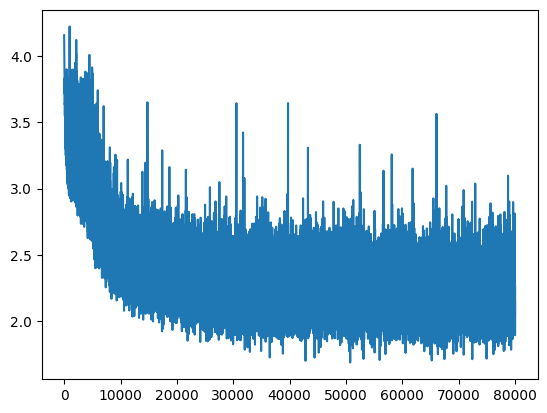

In [12]:
plt.plot(steps, lossi)

In [13]:
def sample(seed_idx, length):
    h = torch.zeros(hidden_size, 1)
    x = torch.zeros(vocab_size, 1)

    x = torch.zeros((vocab_size, 1))  # input (28,1)
    hprev = torch.zeros((hidden_size, 1))  # initial hidden state (200,1)
    cprev = torch.zeros((hidden_size, 1))  # initial cell state (200,1)

    x[seed_idx] = 1
    output = []
    for t in range(length):
        i_t = torch.sigmoid(Wxi @ x + Whi @ hprev + Bi)  # input gate (100,1)
        f_t = torch.sigmoid(Wxf @ x + Whf @ hprev + Bf)  # forget gate (100,1)
        o_t = torch.sigmoid(Wxo @ x + Who @ hprev + Bo)  # output gate (100,1)
        g_t = torch.tanh(Wxg @ x + Whg @ hprev + Bg)  # cell gate (100,1)

        c_t = f_t * cprev + i_t * g_t  # cell state (100,1)
        h_t = o_t * torch.tanh(c_t)  # hidden state (100,1)

        y_t = Why @ h_t + By  # output (28,1)
        for temp in [0.7, 1.0, 1.2]:
            p = f.softmax(y_t / temp, dim=0)
       # p = f.softmax(y_t / temperature, dim=0)
        # p = f.softmax(y_t, dim=0)
        idx = torch.multinomial(p.view(-1), 1).item()  
        x = torch.zeros((vocab_size, 1))  # input (28,1)
        x[idx] = 1
        output.append(idx)
    return output

In [ ]:
# Load best parameters
Wxi = best_checkpoint['Wxi']
Whi = best_checkpoint['Whi']
Bi = best_checkpoint['Bi']
Wxf = best_checkpoint['Wxf']
Whf = best_checkpoint['Whf']
Bf = best_checkpoint['Bf']
Wxo = best_checkpoint['Wxo']
Who = best_checkpoint['Who']
Bo = best_checkpoint['Bo']
Wxg = best_checkpoint['Wxg']
Whg = best_checkpoint['Whg']
Bg = best_checkpoint['Bg']
Why = best_checkpoint['Why']
By = best_checkpoint['By']


NameError: name 'best_checkpoint' is not defined

In [21]:
#load_checkpoint("best_lstm_model.pt")
sampling = sample(stoi[" "], 100)  # seed index and length of sequence to sample
print(''.join(itos[idx] for idx in sampling))  # convert indices back to characters

t. M E curke t lodadretZebt D c; rak gh Altineallemy, Wrroclle! Sto cvinaDrap:, Janr znksteo, I dipe


In [88]:
def load_checkpoint(filename="best_lstm_model.pt"):
    global Wxi, Whi, Bi, Wxf, Whf, Bf
    global Wxo, Who, Bo, Wxg, Whg, Bg
    global Why, By

    checkpoint = torch.load(filename)
    
    Wxi = checkpoint['Wxi']
    Whi = checkpoint['Whi']
    Bi  = checkpoint['Bi']

    Wxf = checkpoint['Wxf']
    Whf = checkpoint['Whf']
    Bf  = checkpoint['Bf']

    Wxo = checkpoint['Wxo']
    Who = checkpoint['Who']
    Bo  = checkpoint['Bo']

    Wxg = checkpoint['Wxg']
    Whg = checkpoint['Whg']
    Bg  = checkpoint['Bg']

    Why = checkpoint['Why']
    By  = checkpoint['By']
